# Denoising handwritten digits using autoencoders

- This is a spinoff from the handwritten digit recognition project. Artificial noise (gaussian) is added to images and the autoencoder will attempt to reconstruct the original image.

Source of code : https://github.com/iitkliv/dlvcnptel/blob/master/lecture12.ipynb

---

## Importing libraries and dataset

In [9]:

%matplotlib inline
import os
import copy
import torch
import codecs
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
from tqdm import tqdm

print(torch.__version__)

1.5.0


In [10]:
# Downloading MNIST dataset
download = datasets.MNIST("../downloads/MNIST/", train=True, download=True)

In [11]:
# Path for storing data
Datapath = "../downloads/MNIST/MNIST/raw/"

## Defining basic functions needed

In [12]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [13]:
def parse_byte(b):
    if isinstance(b, str):
        return ord(b)
    return b

In [14]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(num_rows):
                row = []
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx += 1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1,784)

In [15]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        labels = [parse_byte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)

In [16]:
TrainImages = read_image_file(os.path.join(Datapath, 'train-images-idx3-ubyte'))
TrainLabels = read_label_file(os.path.join(Datapath, 'train-labels-idx1-ubyte'))
TestImages = read_image_file(os.path.join(Datapath, 't10k-images-idx3-ubyte'))
TestLabels = read_label_file(os.path.join(Datapath, 't10k-labels-idx1-ubyte'))

In [17]:
print("Train images size : " + str(TrainImages.size()))
print("Train labels size : " + str(TrainImages.size()))
print("Test images size  : " + str(TrainImages.size()))
print("Test labels size  : " + str(TrainImages.size()))

Train images size : torch.Size([60000, 784])
Train labels size : torch.Size([60000, 784])
Test images size  : torch.Size([60000, 784])
Test labels size  : torch.Size([60000, 784])


In [18]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("GPU is available!")
    device = "cuda"
else:
    print("GPU is not available")
    device = "cpu"

GPU is available!


In [19]:
def add_noise(image, std_dev, dev=device):
    noise = torch.abs(std_dev * torch.randn(*image.shape).to(dev))
    return image + noise

In [20]:
def model_init(m):
    if(isinstance(m, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

## Defining the autoencoder

In [21]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28, 200), nn.ReLU(), nn.Linear(200,100), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(100,200), nn.ReLU(), nn.Linear(200, 28*28), nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
net = autoencoder()
print(net)

net = net.double().to(device)

init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=784, bias=True)
    (3): ReLU()
  )
)


## Defining optimizer

In [22]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=1.5, momentum=0.5)

## Training the autoencoder

In [23]:
net.apply(model_init)
first = True

In [24]:
iterations = 120
BatchSize = 10000
noise = 50

debug = False

for epoch in tqdm(range(iterations)):
    runningLoss = 0
    for i in range(int(TrainImages.shape[0]/BatchSize)):
        inputs = torch.index_select(TrainImages, 0, torch.linspace(i*BatchSize, (i+1)*BatchSize-1, steps=BatchSize).long()).double()
        inputs = inputs/255
        inputs = inputs.to(device)
        
        if(first):
            noised = inputs
        else:
            noised = add_noise(inputs, noise/255)

        optimizer.zero_grad()
        outputs = net(noised)

        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()

        if(debug and i==0):
            plt.subplot(131)
            plt.imshow(inputs[0].view(28,28).cpu())
            plt.subplot(132)
            plt.imshow(noised[0].view(28,28).cpu())
            plt.subplot(133)
            plt.imshow(outputs[0].view(28,28).cpu().detach())
            plt.show()
    
    if(epoch%10==9):
        print(" Iteration : %3d/%3d; loss : %2.3f"%(epoch+1, iterations, runningLoss/(epoch+1)))
    
    if(epoch == 20):
        first = False

print("Finished training")

100%|██████████| 120/120 [02:36<00:00,  1.30s/it] Iteration : 120/120; loss : 0.002
Finished training



## Visualising result


Test set index number : 8428


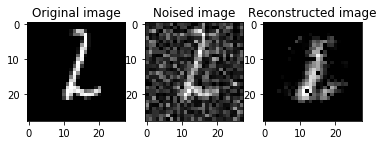


Test set index number : 4136


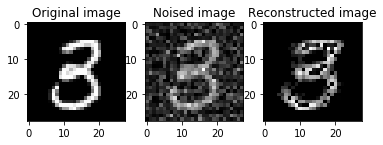


Test set index number : 1784


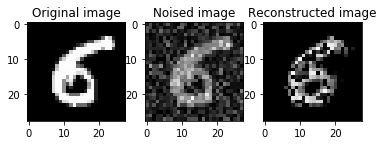


Test set index number : 6477


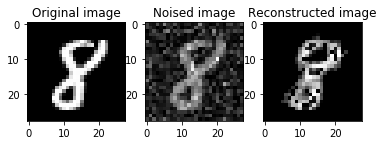


Test set index number : 4954


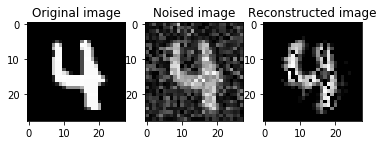


Test set index number : 9139


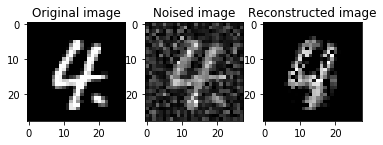


Test set index number : 2295


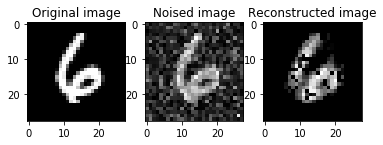


Test set index number : 2158


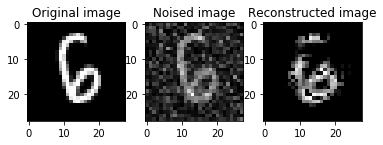


Test set index number : 3721


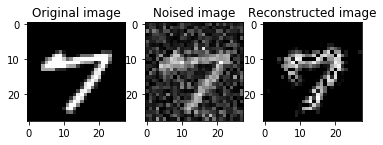


Test set index number : 8453


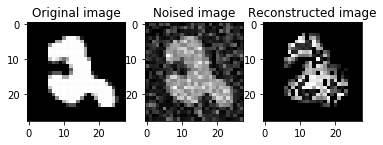

In [33]:
indices = np.random.uniform(0, TestImages.shape[0], size=10)

for i in indices:
    print()
    print("Test set index number : %d"%i)

    test_img = TrainImages[int(i)]

    test_noise = 100
    noised_img = add_noise(test_img, test_noise, "cpu")

    out = net((noised_img.double().to(device))/255)
    output_img = (out.data*255).byte()
    output_img = output_img.view(-1, 28, 28)

    if device == "cuda":
        output_img = output_img.cpu()
        noised_img = noised_img.cpu()

    test_img = test_img.view(-1, 28, 28)
    noised_img = noised_img.view(-1, 28, 28)

    plt.subplot(1,3,1)
    img = np.array(test_img.numpy())[0]
    plt.title("Original image")
    plt.imshow(img, cmap="gray")

    plt.subplot(1,3,2)
    img = np.array(noised_img.numpy())[0]
    plt.title("Noised image")
    plt.imshow(img, cmap="gray")

    plt.subplot(1,3,3)
    out_img = np.array(output_img.numpy())[0]
    plt.title("Reconstructed image")
    plt.imshow(out_img, cmap="gray")

    plt.show()

## Encoder weights visualisation

In [26]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

Text(0.5,1,'Updation of weights')

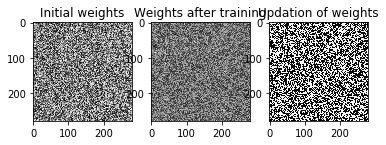

In [27]:
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5

if use_gpu:
    init_weights = init_weights.view(-1, 280, 280).byte().cpu()
    trained_weights = trained_weights.view(-1, 280, 280).byte().cpu()
else:
    init_weights = init_weights.view(-1,280,280).byte()
    trained_weights = trained_weights.view(-1, 280, 280).byte()

d_weights = init_weights - trained_weights

plt.subplot(131)
plt.imshow(init_weights.numpy()[0], cmap="gray")
plt.title("Initial weights")

plt.subplot(132)
plt.imshow(trained_weights.numpy()[0], cmap="gray")
plt.title("Weights after training")

plt.subplot(133)
plt.imshow(d_weights.numpy()[0], cmap="gray")
plt.title("Updation of weights")